## Vehicle detection

The goal of this project is to detect vehicle within an image.
1. Extract HOG and color features. Use SVM as the training model
2. Use convolutional neural network

### 1. Feature extraction

Extract features from an image. We mainly focused on the HOG (Histogram of Oriented Gradient) and the color feature.

#### 1.1 HOG feature

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from skimage.feature import hog

In [2]:
"""
This method returns HOG feature for a binary image.
If vis is True, it also return a HOG feature image.
If vec is True, the HOG feature is unroll.

[Attention] the input image must be a binary image.
"""
def get_hog(img, orient=9, pix_per_cell=8, cell_per_block=2, vis=False, vec=True):
    
    if vis:
        features, hog_img = hog(img, orientations=orient, 
                            pixels_per_cell = (pix_per_cell, pix_per_cell),
                            cells_per_block = (cell_per_block, cell_per_block),
                            block_norm = 'L2-Hys',
                            visualise = True,
                            transform_sqrt = False,
                            feature_vector = vec)
        return features, hog_img
    else:
        features = hog(img, orientations=orient, 
                    pixels_per_cell = (pix_per_cell, pix_per_cell),
                    cells_per_block = (cell_per_block, cell_per_block),
                    block_norm = 'L2-Hys',
                    visualise = False,
                    transform_sqrt = False,
                    feature_vector = vec)
        return features

"""
This method returns a vector that consists of HOG vectors for every image channel.
It doesn't return HOG feature image and the feature vector is unrolled.
"""
def get_hog_all(image, orient=9, pix_per_cell=8, cell_per_block=2):
    feature_vec = []
    for channel in range(image.shape[2]):
        img = image[:, :, channel]
        feature = get_hog(img, orient, pix_per_cell, cell_per_block)
        feature_vec.append(feature)
    return np.hstack(feature_vec)

Visualize HOG feature for vehicle and non-vehicle image

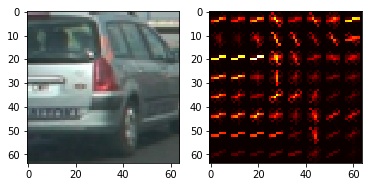

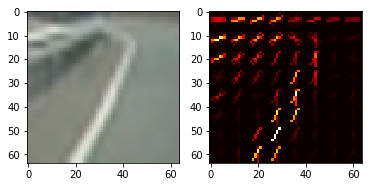

In [3]:
vehicle_img = mpimg.imread('vehicles/GTI_Left/image0168.png')
non_vehicle_img = mpimg.imread('non-vehicles/GTI/image168.png')

features, hog_img = get_hog(vehicle_img[:, :, 0], vis=True)
fig = plt.figure(figsize=(6,4))
plt.subplot(121)
plt.imshow(vehicle_img)
plt.subplot(122)
plt.imshow(hog_img, cmap='hot')
plt.show()

features, hog_img = get_hog(non_vehicle_img[:, :, 0], vis=True)
fig = plt.figure(figsize=(6,4))
plt.subplot(121)
plt.imshow(non_vehicle_img)
plt.subplot(122)
plt.imshow(hog_img, cmap='hot')
plt.show()

#### 1.2 color feature

In [4]:
"""
Convert color space for an image.
"""
def cvt_cspace(image, cspace='RGB'):
    if cspace == 'YCrCb':
        img = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    elif cspace == 'HLS':
        img = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    elif cspace == 'HSV':
        img = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    elif cspace == 'LUV':
        img = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
    elif cspace == 'LAB':
        img = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    else:
        img = image
    return img

"""
This method returns a spatial bin feature for an image.
If vis is True, return the resize image.
"""
def get_bin_spatial(img, size=(32, 32), vis=False):
    ch_1 = cv2.resize(img[:, :, 0], size)
    ch_2 = cv2.resize(img[:, :, 1], size)
    ch_3 = cv2.resize(img[:, :, 2], size)
    feature_vec = np.hstack((ch_1.ravel(), ch_2.ravel(), ch_3.ravel()))
    imgs = []
    imgs.append(ch_1)
    imgs.append(ch_2)
    imgs.append(ch_3)
    if vis:
        return feature_vec, imgs
    else:
        return feature_vec
    
"""
This method returns a histogram of color space.
If vis is True, return the position and value for bars of a histogram.
"""
def get_color_hist(img, nbins=32, vis=False):
    hist_1 = np.histogram(img[:, :, 0], nbins)
    hist_2 = np.histogram(img[:, :, 1], nbins)
    hist_3 = np.histogram(img[:, :, 2], nbins)
    feature_vec = np.hstack((hist_1[0], hist_2[0], hist_3[0]))
    
    if vis:
        bin_edges = hist_1[1]
        bin_centers = (bin_edges[1:] + bin_edges[0:len(bin_edges)-1])/2
        return feature_vec, bin_centers, hist_1[0], hist_2[0], hist_3[0]
    else:
        return feature_vec

Let's take a look at bin spatial feature for YCrCb color space.

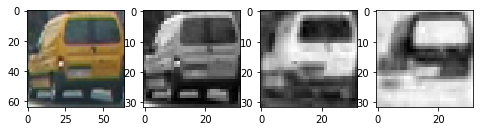

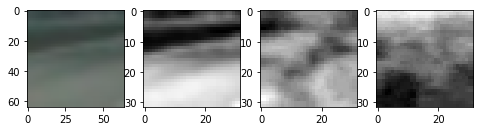

In [5]:
vehicle_img = mpimg.imread('vehicles/GTI_Right/image0862.png')
non_vehicle_img = mpimg.imread('non-vehicles/GTI/image200.png')

vehicle_YCrCb = cvt_cspace(vehicle_img, cspace='YCrCb')
features, small_imgs = get_bin_spatial(vehicle_YCrCb, vis=True)
fig = plt.figure(figsize=(8,6))
plt.subplot(141)
plt.imshow(vehicle_img)
plt.subplot(142)
plt.imshow(small_imgs[0], cmap='gray')
plt.subplot(143)
plt.imshow(small_imgs[1], cmap='gray')
plt.subplot(144)
plt.imshow(small_imgs[2], cmap='gray')
plt.show()

non_vehicle_YCrCb = cvt_cspace(non_vehicle_img, cspace='YCrCb')
features, small_imgs = get_bin_spatial(non_vehicle_YCrCb, vis=True)
fig = plt.figure(figsize=(8,6))
plt.subplot(141)
plt.imshow(non_vehicle_img)
plt.subplot(142)
plt.imshow(small_imgs[0], cmap='gray')
plt.subplot(143)
plt.imshow(small_imgs[1], cmap='gray')
plt.subplot(144)
plt.imshow(small_imgs[2], cmap='gray')
plt.show()

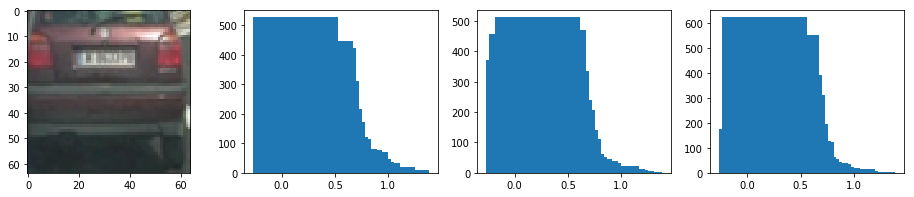

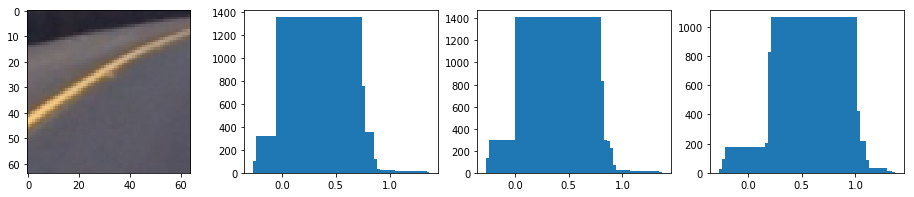

In [6]:
vehicle_img = mpimg.imread('vehicles/GTI_MiddleClose/image0092.png')
non_vehicle_img = mpimg.imread('non-vehicles/Extras/extra1006.png')

imgs = []
imgs.append(vehicle_img)
imgs.append(non_vehicle_img)

for img in imgs:
    features, bin_centers, hist1, hist2, hist3 = get_color_hist(img, vis=True)
    fig = plt.figure(figsize=(16,3))
    plt.subplot(141)
    plt.imshow(img)
    plt.subplot(142)
    plt.bar(bin_centers, hist1)
    plt.subplot(143)
    plt.bar(bin_centers, hist2)
    plt.subplot(144)
    plt.bar(bin_centers, hist3)
    plt.show()

#### 1.3 Combine HOG and color feature

In [7]:
"""
Extract feature from an image.
"""
def extract_feature_from_image(image, cspace='YCrCb', 
                               size=(32, 32), nbins=32, 
                               orient=9, pix_per_cell=8, cell_per_block=2):
    img = cvt_cspace(image, cspace)
    color_hist = get_color_hist(img, nbins)
    sp_bin = get_bin_spatial(img, size)
    hog = get_hog_all(img, orient, pix_per_cell, cell_per_block)
    vec = np.hstack((color_hist, sp_bin, hog))
    return vec

"""
Extract feature from a list of images and return a concatenated feature.
"""
def extract_features_from_imgs(imgs, cspace='YCrCb', 
                               size=(32, 32), nbins=32, 
                               orient=6, pix_per_cell=8, cell_per_block=2):
    features = []
    for img in imgs:
        feature = extract_feature_from_image(img, cspace, size, nbins, orient, pix_per_cell, cell_per_block)
        features.append(feature)
    return features

### 2. Train the model

#### 2.1 Read in car / not car images

In [8]:
import glob

car_files = glob.glob('./vehicles/*/*')
not_car_files = glob.glob('./non-vehicles/*/*')

car_imgs = []
not_car_imgs = []
for car_file in car_files:
    car_img = mpimg.imread(car_file)
    car_imgs.append(car_img)
    
for not_car_file in not_car_files:
    not_car_img = mpimg.imread(not_car_file)
    not_car_imgs.append(not_car_img)
    
print('Number of vehicle images:', len(car_imgs))
print('Number of non-vehicle images:', len(not_car_imgs))
print('Shape of the image:', car_imgs[0].shape)

Number of vehicle images: 8792
Number of non-vehicle images: 8968
Shape of the image: (64, 64, 3)


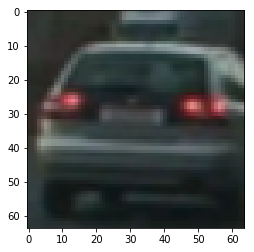

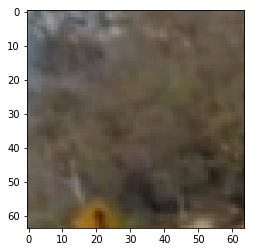

In [9]:
plt.imshow(car_imgs[666])
plt.show()
plt.imshow(not_car_imgs[777])
plt.show()

#### 2.2 Extract and normalize features.

1. Extract features
2. Normalize features
3. Split train/test data

In [10]:
orientation = 9
pix = 8
cell = 2
bins =32
sz = (32, 32)

In [11]:
car_features = extract_features_from_imgs(car_imgs, size=sz, nbins=bins, 
                               orient=orientation, pix_per_cell=pix, cell_per_block=cell)
not_car_features = extract_features_from_imgs(not_car_imgs, size=sz, nbins=bins, 
                               orient=orientation, pix_per_cell=pix, cell_per_block=cell)
print(len(car_features))
print(len(not_car_features))
print(car_features[0].shape)

8792
8968
(8460,)


In [12]:
X = np.vstack((car_features, not_car_features)).astype(np.float64)
y = np.hstack((np.ones(len(car_features)), np.zeros(len(not_car_features))))
print(X.shape)
print(y.shape)

(17760, 8460)
(17760,)


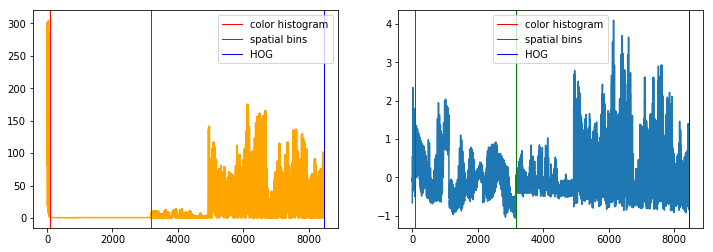

In [14]:
# Normalize
from sklearn.preprocessing import StandardScaler

X_scaler = StandardScaler().fit(X)
scaled_X = X_scaler.transform(X)

fig = plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(X[0], color='orange')
plt.axvline(x=96, linewidth=1, color='r', label='color histogram')
plt.axvline(x=3168, linewidth=1, color='g', label='spatial bins')
plt.axvline(x=8460, linewidth=1, color='b', label='HOG')
plt.legend()

plt.subplot(122)
plt.plot(scaled_X[0])
plt.axvline(x=96, linewidth=1, color='r', label='color histogram')
plt.axvline(x=3168, linewidth=1, color='g', label='spatial bins')
plt.axvline(x=8460, linewidth=1, color='b', label='HOG')
plt.legend()
plt.show()

In [15]:
# Split data
from sklearn.model_selection import train_test_split

rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(14208, 8460)
(14208,)
(3552, 8460)
(3552,)


#### 2.3 Train the model

In [16]:
from sklearn.svm import LinearSVC
from sklearn import svm
from sklearn.model_selection import GridSearchCV
import time

In [17]:
t1 = time.time()
linear_clf = LinearSVC()
linear_clf.fit(X_train, y_train)
t2 = time.time()
acc = linear_clf.score(X_test, y_test)
print("Time: ", round(t2-t1, 5), ' Accuracy: ', acc)

Time:  22.43746  Accuracy:  0.987331081081


In [18]:
t1 = time.time()
rbf_clf = svm.SVC(kernel='rbf', C=10)
rbf_clf.fit(X_train, y_train)
t2 = time.time()
acc = rbf_clf.score(X_test, y_test)
print('Time: ', round(t2-t1, 5), ' Accuracy: ' ,acc)

Time:  239.31572  Accuracy:  0.993806306306


### 3. Sliding Window Search

In [19]:
"""
Given a list of bounding boxes, draw them on the image.
"""
def draw_boxes(image, bboxes, color=(0, 0, 255), thickness=6):
    img = np.copy(image)
    for bbox in bboxes:
        cv2.rectangle(img, bbox[0], bbox[1], color, thickness)
    return img

#### 3.1 Same window size

Let's implement the very basic version of searching algorithm. It creates sliding windows with the same size.

In [20]:
def slid_win(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
        
    # Range in x,y direction
    range_x = x_start_stop[1] - x_start_stop[0]
    range_y = y_start_stop[1] - y_start_stop[0]
    # Pixels per step in x,y direction
    x_step_pix = np.int(xy_window[0] * (1-xy_overlap[0]))
    y_step_pix = np.int(xy_window[1] * (1-xy_overlap[1]))
    # Buffer in x,y direction
    x_buffer = np.int(xy_window[0] * xy_overlap[0])
    y_buffer = np.int(xy_window[1] * xy_overlap[1])
    # Number of windows
    n_win_x = np.int((range_x - x_buffer)/x_step_pix)
    n_win_y = np.int((range_y - y_buffer)/y_step_pix)
    
    bboxes = []
    for i in range(n_win_x):
        for j in range(n_win_y):
            top_left_x = x_step_pix * i + x_start_stop[0]
            top_left_y = y_step_pix * j + y_start_stop[0]
            bottom_right_x = top_left_x + xy_window[0]
            bottom_right_y = top_left_y + xy_window[1]
            bboxes.append(((top_left_x, top_left_y), (bottom_right_x, bottom_right_y)))
    return bboxes

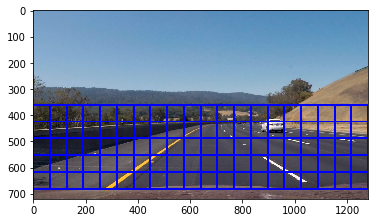

In [21]:
img = mpimg.imread('./test_images/test3.jpg')

bboxes = slid_win(img, y_start_stop=[np.int(img.shape[0]/2), img.shape[0]], 
                    xy_window=(128, 128))
out = draw_boxes(img, bboxes)
plt.imshow(out)
plt.show()

#### 3.2 Perspective sliding windows

Perspective sliding windows take into the account of perspective transformation. The farther the window it is, the smaller it appears; The closer the window it is, the larger it appears.

In [22]:
"""
Perspective sliding window. 

Inputs:
x_start_stop, y_start_stop: defines the region of interest
xy_window: defines the TOP-MOST window size
xy_overlap: defines the ratio of overlaping area between two windows
ratio: (1 + y_distance * ratio) would be the size of a new window

Outputs:
A list of bounding boxes.
"""
def perspective_slid_win(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(32, 32), xy_overlap=(0.5, 0.5), ratio=1/300.):
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
     
    bboxes = []
    win = xy_window # current window size
    top = y_start_stop[0] # upper bound of bbox
    bottom = top + win[1] # lower bound of bbox
    
    while bottom <= y_start_stop[1]:
        left = x_start_stop[0]
        right = left + win[0]
        pix_x = np.int(win[0]*(1-xy_overlap[0])) # pixel per step in x direction
        while right <= x_start_stop[1]:
            bboxes.append(((left, top), (right, bottom)))
            left += pix_x
            right = left + win[0]
        # update window size
        pix_y = np.int(win[1]*(1-xy_overlap[1])) # pixel per step in y direction
        scale = 1 + pix_y * ratio
        win_x = np.int(win[0]*scale)
        win_y = np.int(win[1]*scale)
        win = (win_x, win_y)
        top += pix_y
        bottom = top + win[1]
    return bboxes

In [23]:
"""
This function is similar to the above method. 
The only difference is that the sliding window starts from the right side instead of left side.
"""
def perspective_slid_win_right(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(32, 32), xy_overlap=(0.5, 0.5), ratio=1/300.):
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
     
    bboxes = []
    win = xy_window # current window size
    top = y_start_stop[0] # upper bound of bbox
    bottom = top + win[1] # lower bound of bbox
    
    while bottom <= y_start_stop[1]:
        right = x_start_stop[1]
        left = right - win[0]
        pix_x = np.int(win[0]*(1-xy_overlap[0])) # pixel per step in x direction
        while left >= x_start_stop[0]:
            bboxes.append(((left, top), (right, bottom)))
            right -= pix_x
            left = right - win[0]
        # update window size
        pix_y = np.int(win[1]*(1-xy_overlap[1])) # pixel per step in y direction
        scale = 1 + pix_y * ratio
        win_x = np.int(win[0]*scale)
        win_y = np.int(win[1]*scale)
        win = (win_x, win_y)
        top += pix_y
        bottom = top + win[1]
    return bboxes

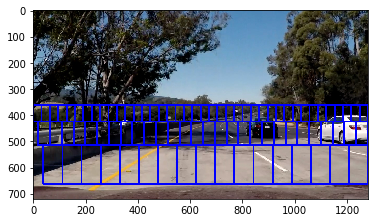

In [24]:
img = mpimg.imread('./test_images/test5.jpg')

bboxes = perspective_slid_win_right(img, y_start_stop=[np.int(img.shape[0]/2), img.shape[0]], xy_window=(64, 64), xy_overlap=(0.5, 0), ratio=1/150.)
out = draw_boxes(img, bboxes)
plt.imshow(out)
plt.show()

#### 3.3 Multi-scale sliding window

Now that we've implemented a perspective sliding window algorithm, we can feed it with various window sizes for the top-most windows

In [25]:
"""
Generate sliding windows with multi scales.
win_small: small window size
win_big: big window size
inc: increment from small to big window size
"""
def multi_slid_win(img, x_start_stop=[None, None], y_start_stop=[None, None],
                  win_small=32, win_big=64, inc=8,
                  overlap=(0.5, 0.5), r=1/300.):
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
        
    bboxes = []
    win = win_small
    while win <= win_big:
        win_x = win
        win_y = np.int(win*0.5)
        out = perspective_slid_win(img, x_start_stop, y_start_stop, xy_window=(win_x, win_y), xy_overlap=overlap, ratio=r)
        bboxes.extend(out)
        win += inc
    return bboxes

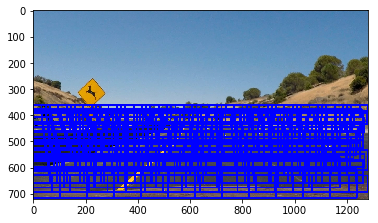

In [26]:
img = mpimg.imread('./test_images/test2.jpg')

bboxes = multi_slid_win(img, y_start_stop=[np.int(img.shape[0]/2), img.shape[0]], win_small=64, win_big=128, inc=32)
out = draw_boxes(img, bboxes)
plt.imshow(out)
plt.show()

### 4. Search vehicle and apply heatmap

In [29]:
# HOG params
orient = 9
pix_per_cell = 8
cell_per_block = 2
# Color feature params
cspace='YCrCb'
nbins = 32
size = (32, 32)
# Overlap
cells_per_step = 2 # This means 75% overlap

In [30]:
def search_windows(image, windows, clf, scaler):
    pos_wins = [] # windows contains positive result
    for win in windows:
        img = image[win[0][1]:win[1][1], win[0][0]:win[1][0], :]
        
        img = cv2.resize(img, (64, 64))
        feature = extract_feature_from_image(img, size=sz, nbins=bins, orient=orientation, pix_per_cell=pix, cell_per_block=cell)
        X = scaler.transform(np.array(feature).reshape(1, -1))
        y = clf.predict(X)
        if y == 1:
            pos_wins.append(win)
    return pos_wins

In [31]:
"""
Get a heatmap given positive windows and a threshold.
"""
def get_heatmap(img, pos_wins, threshold):
    heatmap = np.zeros_like(img[:,:,0]).astype(np.float)
    for win in pos_wins:
        # Add 1 for each pixel within the box
        heatmap[win[0][1]:win[1][1], win[0][0]:win[1][0]] += 1
    heatmap[heatmap <= threshold] = 0
    return heatmap

In [33]:
"""
Generate sliding windows using:
normal slid_win 
or perspective_slid_win 
or multi_slid_win 
or any combination of them.
"""
def gen_slid_wins(img):
    wins = []
    
    bboxes1 = perspective_slid_win_right(img, y_start_stop=[400, img.shape[0]], xy_window=(64, 64), xy_overlap=(0.6, 0.6), ratio=1/150.)
    bboxes2 = perspective_slid_win_right(img, y_start_stop=[400, img.shape[0]], xy_window=(96, 96), xy_overlap=(0.6, 0.6), ratio=1/150.)
    bboxes3 = perspective_slid_win_right(img, y_start_stop=[420, img.shape[0]], xy_window=(100, 50), xy_overlap=(0.6, 0.6), ratio=1/150.)
    bboxes4 = perspective_slid_win_right(img, y_start_stop=[420, img.shape[0]], xy_window=(120, 60), xy_overlap=(0.6, 0.6), ratio=1/150.)
    
    wins.extend(bboxes1)
    wins.extend(bboxes2)
    wins.extend(bboxes3)
    wins.extend(bboxes4)
    
    return wins

In [34]:
def draw_labeled_bboxes(image, labels):
    img = np.copy(image)
    # Different color for different boxes
    colors = [(127, 255, 0), (255, 127, 255), (255, 127, 0)]
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        color = colors[car_number % len(colors)]
        cv2.rectangle(img, bbox[0], bbox[1], color, 6)
    # Return the image
    return img

In [35]:
from scipy.ndimage.measurements import label

def find_cars(image, diag=False):
    img = image.astype(np.float32)/255
    
    wins = gen_slid_wins(img)
    # Search for cars
    pos_wins = search_windows(img, wins, rbf_clf, X_scaler)
    car_pos = draw_boxes(image, pos_wins)
    # Generate heatmap
    heatmap = get_heatmap(img, pos_wins, 1)
    heatmap = np.clip(heatmap, 0, 255)
    # Label cars
    labels = label(heatmap)
    labeled_cars = draw_labeled_bboxes(image, labels)
    
    if diag:
        # Display results
        fig = plt.figure(figsize=(16,12))
        plt.subplot(131)
        plt.imshow(car_pos)

        plt.subplot(132)
        plt.imshow(heatmap, cmap='hot')

        plt.subplot(133)
        plt.imshow(labeled_cars)
        plt.show()
    
    return labeled_cars, heatmap

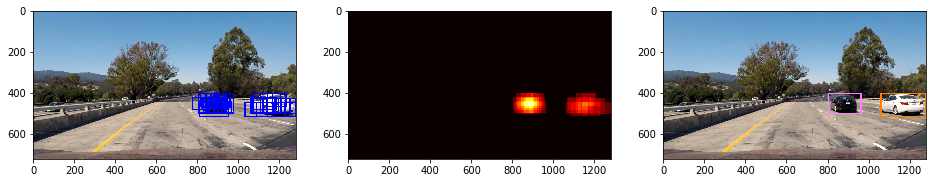

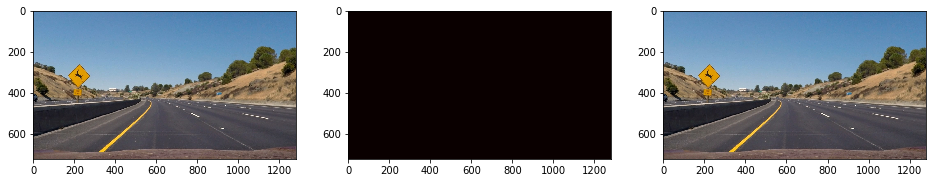

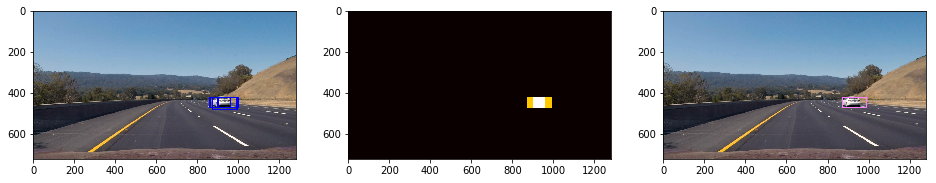

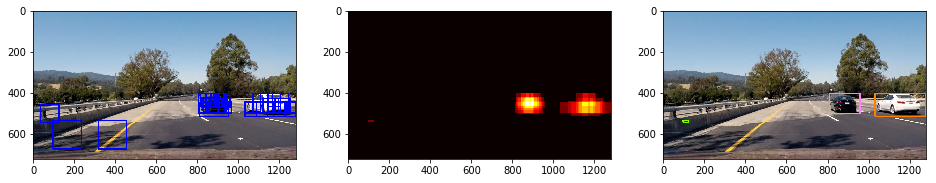

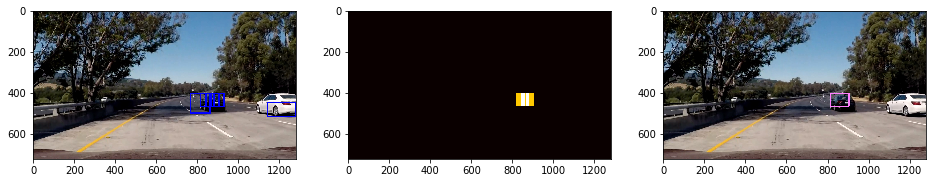

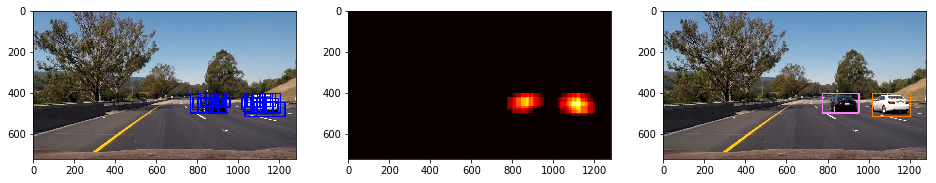

In [36]:
files = glob.glob('./test_images/test*.jpg')
for file in files:
    image = mpimg.imread(file)
    find_cars(image, diag=True) 

### 5. Improvement

There are two major improvements:
1. Create a 'Cars' object to keep track of previous n frames of labeled car information.
2. Extract HOG feature once and this can decrease the feature extraction time a lot!

In [182]:
# HOG params
orient = 9
pix_per_cell = 8
cell_per_block = 2
# Color feature params
cspace='YCrCb'
nbins = 32
size = (32, 32)
# Overlap
cells_per_step = 2 # This means 75% overlap

In [183]:
"""
This method combines all features extraction methods in one place (color histogram, bin spatial and HOG)
What's more, it only extracts HOG feature once.

Credit to Udacity.
"""
def locate_cars(image, scale, scaler, clf):
    window = 64
    ystart = 400
    ystop = image.shape[0]
    
    # Image to search and convert to other color spaces
    img = image[ystart:ystop, :, :]
    img = cvt_cspace(img, cspace)
    if scale != 1:
        imshape = img.shape
        img = cv2.resize(img, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
    
    # number of blocks across the image
    nxblocks = (img.shape[1] // pix_per_cell) - 1
    nyblocks = (img.shape[0] // pix_per_cell) - 1
    nfeat_per_block = orient * (pix_per_cell)**2
    #print(nxblocks, nyblocks, nfeat_per_block)
    
    # number of blocks per window and step
    nblocks_per_window = (window // pix_per_cell) - 1
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    #print(nblocks_per_window, nxsteps, nysteps)
    
    # Extract HOG feature once
    hog1 = get_hog(img[:,:,0], orient, pix_per_cell, cell_per_block, False, False)
    hog2 = get_hog(img[:,:,1], orient, pix_per_cell, cell_per_block, False, False)
    hog3 = get_hog(img[:,:,2], orient, pix_per_cell, cell_per_block, False, False)
    
    # Search for positive results
    pos_wins = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            xpos = xb * cells_per_step
            ypos = yb * cells_per_step
            
            # Extract HOG feature
            hog_fea1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_fea2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_fea3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog = np.hstack((hog_fea1, hog_fea2, hog_fea3))
            
            # Get the image
            xleft = xpos * pix_per_cell
            ytop = ypos * pix_per_cell
            sub_img = img[ytop:ytop+window, xleft:xleft+window]
            sub_img = cv2.resize(sub_img, (64, 64))
            
            # Get bin spatial and hist
            color_hist = get_color_hist(sub_img, nbins)
            sp_bin = get_bin_spatial(sub_img, size)
            
            feature = np.hstack((color_hist, sp_bin, hog))
            scaled_feature = scaler.transform(np.array(feature).reshape(1, -1))
            prediction = clf.predict(scaled_feature)
            
            if prediction == 1:
                left = np.int(xleft * scale)
                top = np.int(ytop * scale) + ystart
                win = np.int(window * scale)
                pos_wins.append(((left, top), (left+win, top+win)))
    return pos_wins

In [184]:
import matplotlib.cm as cm
import skimage.color

def process_image(image, diagnosis=False):
    labeled_cars, heatmap = cars.detect_cars(image)
    result = labeled_cars
    
    if diagnosis:
        # Calculate the size of screens
        result_screen_w = result.shape[1]
        result_screen_h = result.shape[0]
        diag_screen_w = np.int(result_screen_w / 3)
        diag_screen_h = np.int(result_screen_h / 3)
        screen_w = result_screen_w + diag_screen_w
        screen_h = result_screen_h
        # Assign result image to the screen
        screen = np.zeros((screen_h, screen_w, 3), dtype=np.uint8)
        screen[0:result_screen_h, 0:result_screen_w] = result
        # Assgin diagnosis image to the screen
        # Get heatmap
        heatmap = np.clip(heatmap, 0, 255)
        m = cm.ScalarMappable(cmap=cm.rainbow)
        heat = m.to_rgba(heatmap)
        heat = skimage.color.rgba2rgb(heat)
        heat = (heat * 255).astype(np.uint8)
        screen[0:diag_screen_h, result_screen_w:] = cv2.resize(heat, (diag_screen_w, diag_screen_h))
        return screen
    else:
        return result

In [185]:
"""
A 'Cars' object is used to keep track of previous N records.
"""
class Cars:
    def __init__(self):
        self.n = 8 # keep track of current n frame of heatmap
        self.ratio = 5 # threshold ratio
        self.curr_heatmap = [] # heatmaps for the most current n frame
        
    def detect_cars(self, image):
        # Scale image to (0, 1.) range
        img = image.astype(np.float32)/255
        # Search for cars
        pos_wins = []
        pos_win1 = locate_cars(img, 1, X_scaler, rbf_clf)
        pos_win2 = locate_cars(img, 1.5, X_scaler, rbf_clf)
        pos_wins.extend(pos_win1)
        pos_wins.extend(pos_win2)
        #car_pos = draw_boxes(image, pos_wins)
        #plt.imshow(car_pos)
        #plt.show()
        # Generate heatmap
        heatmap = get_heatmap(img, pos_wins, 0)
        #plt.imshow(heatmap, cmap='hot')
        #plt.show()
        # Add to current heatmap array
        self.curr_heatmap.append(heatmap)
        # keep only n records
        if (len(self.curr_heatmap) > self.n):
            self.curr_heatmap = self.curr_heatmap[-self.n:]
        
        # Sum the heatmap
        count = len(self.curr_heatmap)
        #print('average over: ', count, ' frames')
        sum_heat = np.zeros_like(heatmap)
        for i in range(count):
            sum_heat += self.curr_heatmap[i]
        thres = np.int(count * self.ratio)
        sum_heat[sum_heat <= thres] = 0
        # Average summed heatmap
        heatmap_avg = sum_heat // count
        
        # Label cars
        labels = label(heatmap_avg)
        labeled_cars = draw_labeled_bboxes(image, labels)
        return labeled_cars, heatmap_avg

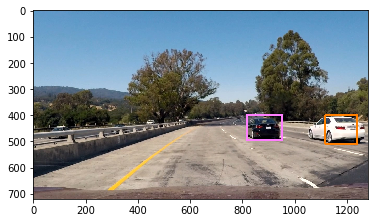

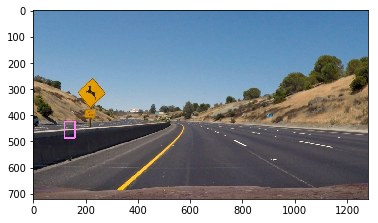

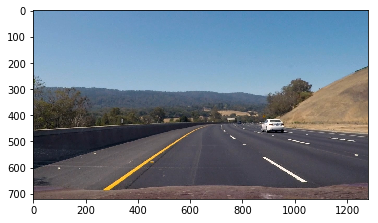

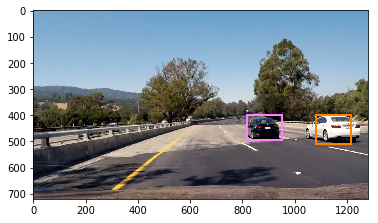

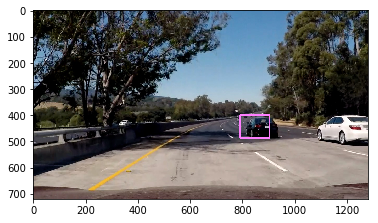

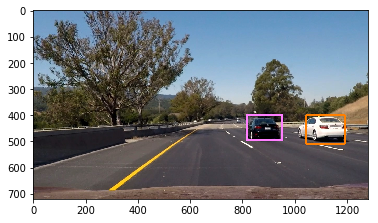

In [181]:
files = glob.glob('./test_images/test*.jpg')
for file in files:
    cars = Cars()

    image = mpimg.imread(file)
    out = process_image(image)
    plt.imshow(out)
    plt.show()

### 5. Test on Videos

In [186]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [188]:
cars = Cars()

white_output = 'test_video_out.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_video_out.mp4
[MoviePy] Writing video test_video_out.mp4



 97%|█████████▋| 38/39 [17:31<00:26, 26.82s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_out.mp4 

CPU times: user 17min 27s, sys: 3.48 s, total: 17min 30s
Wall time: 17min 31s


In [189]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [196]:
cars = Cars()

yellow_output = 'project_video_out.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('project_video.mp4')
yellow_clip = clip2.fl_image(process_image).subclip(0, 20)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4



 61%|██████    | 304/501 [52:03<33:32, 10.21s/it]


100%|█████████▉| 500/501 [1:25:46<00:11, 11.57s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 

CPU times: user 1h 25min 17s, sys: 29.2 s, total: 1h 25min 46s
Wall time: 1h 25min 47s


In [197]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

In [198]:
cars = Cars()

yellow_output = 'project_video_out.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('project_video.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4



 23%|██▎       | 293/1261 [50:23<2:43:58, 10.16s/it]


 46%|████▌     | 577/1261 [1:38:41<1:56:03, 10.18s/it]


 68%|██████▊   | 859/1261 [2:26:38<1:08:43, 10.26s/it]


 91%|█████████ | 1146/1261 [3:15:28<19:34, 10.22s/it]


100%|█████████▉| 1260/1261 [3:34:51<00:10, 10.25s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 

CPU times: user 3h 33min 40s, sys: 1min 12s, total: 3h 34min 53s
Wall time: 3h 34min 52s


## Trick

Read png, jpg, with cv2.imread and mpimg

In [243]:
jpg_mp = mpimg.imread('./test_images/test5.jpg')
jpg_cv = cv2.imread('./test_images/test5.jpg')
png_mp = mpimg.imread('vehicles/GTI_MiddleClose/image0092.png')
png_cv = cv2.imread('vehicles/GTI_MiddleClose/image0092.png')

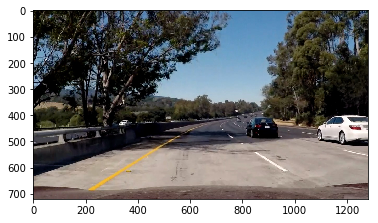

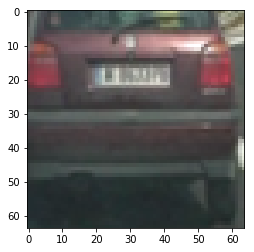

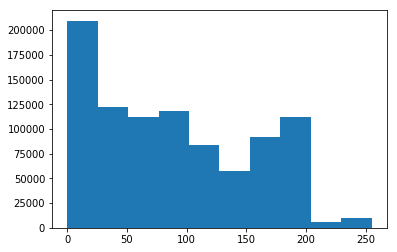

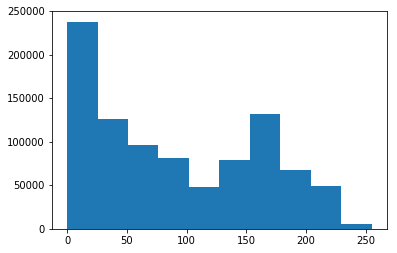

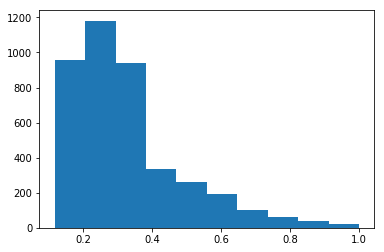

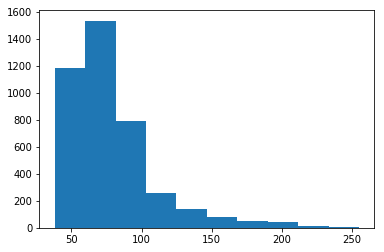

In [247]:
plt.imshow(jpg_mp)
plt.show()
plt.imshow(png_mp)
plt.show()
plt.hist(jpg_mp[:,:,0].ravel())
plt.show()
plt.hist(jpg_cv[:,:,0].ravel())
plt.show()
plt.hist(png_mp[:,:,0].ravel())
plt.show()
plt.hist(png_cv[:,:,0].ravel())
plt.show()